Import dataset.

In [ ]:
!pip install datasets

from datasets import load_dataset
from torch.utils.data import Dataset
import copy
import spacy
import torchtext
from torchtext.legacy.data import Field, BucketIterator, TabularDataset
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import torch
from tensorflow import keras
import math
import torch.nn as nn
from torch.autograd import Variable
import time
import torch.nn.functional as F

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 8.1 MB/s 
     |████████████████████████████████| 1.1 MB 57.1 MB/s 
     |████████████████████████████████| 212 kB 60.2 MB/s 
     |████████████████████████████████| 101 kB 13.5 MB/s 
     |████████████████████████████████| 140 kB 72.9 MB/s 
     |████████████████████████████████| 596 kB 50.9 MB/s 
     |████████████████████████████████| 127 kB 61.1 MB/s 
     |████████████████████████████████| 271 kB 74.5 MB/s 
     |████████████████████████████████| 144 kB 67.0 MB/s 
     |████████████████████████████████| 94 kB 4.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dep

ModuleNotFoundError: ignored

In [ ]:
import torch
a=torch.ones(2,2)
print(a==0)

tensor([[False, False],
        [False, False]])


In [ ]:
device = "cuda" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
en = spacy.load('en')
def tokenize_en(sentence):
    return [tok.text for tok in en.tokenizer(sentence)]
EN_TEXT = Field(tokenize=tokenize_en)
SQL_TEXT = Field(tokenize=tokenize_en)

We work on the spider data-set, convert format into: query -> answer

In [ ]:
spider = load_dataset('spider')

Downloading:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/837 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/99.7M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset spider downloaded and prepared to /root/.cache/huggingface/datasets/spider/spider/1.0.0/79778ebea87c59b19411f1eb3eda317e9dd5f7788a556d837ef25c3ae6e5e8b7. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
train_set = spider.get('train')
tokenize_en(train_set[1]['query'])

['SELECT',
 'name',
 ',',
 ' ',
 'born_state',
 ',',
 ' ',
 'age',
 'FROM',
 'head',
 'ORDER',
 'BY',
 'age']

In [ ]:
raw_data = {'Text' : [line for line in train_set['question']], 'SQL': [line for line in train_set['query']]}
df = pd.DataFrame(raw_data, columns=["Text", "SQL"])
# remove very long sentences and sentences where translations are 
# not of roughly equal length
df['text_len'] = df['Text'].str.count(' ')
df['sql_len'] = df['SQL'].str.count(' ')
#removing very long queries and questions 
df = df.query('sql_len < 80 & text_len < 80')
df = df.query('sql_len < text_len * 1.5 & sql_len * 1.5 > text_len')

In [ ]:
df

,Text,SQL,text_len,sql_len
0,How many heads of the departments are older th...,SELECT count(*) FROM head WHERE age > 56,10,9
1,"List the name, born state and age of the heads...","SELECT name , born_state , age FROM head ORD...",14,12
2,"List the creation year, name and budget of eac...","SELECT creation , name , budget_in_billions ...",9,9
7,What are the names of the states where at leas...,SELECT born_state FROM head GROUP BY born_stat...,13,12
9,Show the name and number of employees for the ...,"SELECT T1.name , T1.num_employees FROM depart...",18,24
...,...,...,...,...
6986,What is the title and director for the movie w...,"SELECT title , director FROM movie WHERE YEAR...",18,18
6987,Return the title and director of the movie rel...,"SELECT title , director FROM movie WHERE YEAR...",20,18
6990,Show all director names who have a movie in th...,SELECT director FROM movie WHERE YEAR = 1999...,13,15
6992,"What is the average, maximum, and minimum budg...","SELECT avg(budget_million) , max(budget_milli...",12,15


In [ ]:
# create train and validation set 
train, val = train_test_split(df, test_size=0.1)
train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)

In [ ]:
# associate the text in the 'Text' column with the EN_TEXT field, and 'SQL' with SQL_TEXT
data_fields = [('Text', EN_TEXT), ('SQL', SQL_TEXT)]
train, val = TabularDataset.splits(path='./', train='train.csv', validation='val.csv', format='csv', fields=data_fields)

In [ ]:
SQL_TEXT.build_vocab(train, val)
EN_TEXT.build_vocab(train, val)

In [ ]:
#tokens for some example words in the SQL queries and the Text data
print(SQL_TEXT.vocab.stoi['SELECT'])
print(EN_TEXT.vocab.stoi['What'])

4
7


In [ ]:
train_iter = BucketIterator(train, batch_size=20, sort_key=lambda x: len(x.SQL), shuffle=True)
val_iter = BucketIterator(val, batch_size=20, sort_key=lambda x: len(x.SQL), shuffle=True)

In [ ]:
#an example of a batch
batch = next(iter(train_iter))
print(batch.SQL)
print(batch.Text)
#all the 1s are paddings

#FINDING MAX INPUT NORM
max_inp_norm = -1
for i, batch in enumerate(train_iter):
    for j in batch.Text:
        max_inp_norm = max(max_inp_norm, torch.linalg.norm(j.to(torch.float)))

print(max_inp_norm)

tensor([[   4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,    4,
            4,    4,    4,    4,    4,    4,    4,    4],
        [  27,  972, 1055,   27,   24,   15, 1202, 2507,  698,   15,   27,  754,
           50,   58,  337,  612, 1957,  577, 2150,  966],
        [ 135,    3,    9,   79,    3,   11,    3,    9,    3,   11,  604,    5,
          135,    3,    3,    9,    9,    9,    9,    3],
        [   3,  181,    2,    3,  393,   12,  324,    2,  178,   12,    3,    9,
            5,  124,  417,    2,    2,    2,    2,  398],
        [ 143,    6,  345, 2167,    6,    5,   17, 2521,    6,    5,  339,    2,
            3,    6,    6, 1669, 1958, 1803, 2145,    6],
        [   6,  385,    3,    1,  749,    3,   25,    9,  364,    3,   17,  756,
           74,  167,  448,    3,    9,    3,    3,  966],
        [  63,    2,  395,    1,   64,  115,   22,    2,    2,  346,   25,    5,
            1,   32,    2,   92,    2,  985,  133,   38],
        [   2,    7,   14, 

In [ ]:
batch_val = next(iter(val_iter))
print(batch_val.SQL.shape)

torch.Size([28, 20])


In [ ]:
print("Length of training set: " + str(len(spider.get('train'))) + '\n')
data_example = spider.get('train')[0]
y = data_example['query']
x = data_example['question']
print("Example of training data:")
print('\n'.join([(str(key) + ': ' + str(data_example[key])) for key in data_example]))

#Convert input into numpy -------

Length of training set: 7000

Example of training data:
db_id: department_management
query: SELECT count(*) FROM head WHERE age  >  56
question: How many heads of the departments are older than 56 ?
query_toks: ['SELECT', 'count', '(', '*', ')', 'FROM', 'head', 'WHERE', 'age', '>', '56']
query_toks_no_value: ['select', 'count', '(', '*', ')', 'from', 'head', 'where', 'age', '>', 'value']
question_toks: ['How', 'many', 'heads', 'of', 'the', 'departments', 'are', 'older', 'than', '56', '?']


Embedding

In [ ]:
#https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec

#Gives word vector

class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model): #first parameter: total number of unique words. second parameter: the length of the embeddings
        super().__init__()
        #Create embedding function
        self.embed = nn.Embedding(vocab_size, d_model) #can be pretrained too, some extra steps for that
    def forward(self, x):
        #Embed
        return self.embed(x)

Positional Encoding

In [ ]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 200, dropout = 0.1):
        super().__init__()
        self.d_model = d_model #the length of the embeddings
        self.dropout = nn.Dropout(dropout)
        # create constant 'pe' matrix with values dependant on 
        # pos and i. This will come to work in forward pass
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
 
    
    def forward(self, x):
        # multiply the values of embeddings with the square of the length of embeddings. To fix vansihing gradients or something ig
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        pe = Variable(self.pe[:,:seq_len], requires_grad=False) #takes values from self.pe according to the length of the input text string
        if x.is_cuda:
            pe.cuda()
        x = x + pe
        return self.dropout(x)
        #combines input with pe and returns



Multi Head Attention Layer and Attention Scores

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, scale_factor, mask=None):
        
        bs = q.size(0)
        
        # perform linear operation and split into h heads
        
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * h * sl * d_model
       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2) * scale_factor
        # calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)
        #use the scale factor as mentioned in dt_fixup
        output = self.out(concat) * scale_factor
    
        return output

In [ ]:
def attention(q, k, v, d_k, mask=None, dropout=None):
    
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    return output

In [ ]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

Encoder Decoder Layer Classes.

In [ ]:
# build an encoder layer with one multi-head attention layer and one # feed-forward layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        #self.norm_1 = Norm(d_model)
        #self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, scale_factor, mask):
        x2 = x #self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,scale_factor,mask))
        x2 = x #self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x
    
# build a decoder layer with two multi-head attention layers and
# one feed-forward layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        #self.norm_1 = Norm(d_model)
        #self.norm_2 = Norm(d_model)
        #self.norm_3 = Norm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = MultiHeadAttention(heads, d_model)
        self.attn_2 = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
    def forward(self, x, e_outputs, scale_factor, src_mask, trg_mask):
        x2 = x #self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, scale_factor, trg_mask))
        x2 = x #self.norm_2(x)
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs, scale_factor, src_mask))
        x2 = x #self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x
# We can then build a convenient cloning function that can generate multiple layers:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [ ]:
#change N to tune the number of multi headed attention layers

class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        #self.norm = Norm(d_model)
    def forward(self, src, scale_factor, mask):
        x = self.embed(src)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, scale_factor, mask)
        return x #self.norm(x)
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        #self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, scale_factor, src_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, scale_factor, src_mask, trg_mask)
        return x #self.norm(x)

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__() 
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)#*scale_factor
        return x

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, scale_factor, d_model, N, heads):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads)
        self.decoder = Decoder(trg_vocab, d_model, N, heads)
        self.out = nn.Linear(d_model, trg_vocab)
        self.scale_factor = scale_factor
    def forward(self, src, trg, src_mask, trg_mask):
        encoder_outputs = self.encoder(src, self.scale_factor, src_mask)
        decoder_output = self.decoder(trg, encoder_outputs, self.scale_factor, src_mask, trg_mask)
        output = self.out(decoder_output)
        return output
# we don't perform softmax on the output as this will be handled 
# automatically by our loss function

In [ ]:
#this is what will have to be tuned
from math import sqrt

d_model = 512
heads = 8
N = 6
scale_factor = 1/(2 * sqrt(N) * max_inp_norm) #scale factor as defined in dt fixup
src_vocab = len(EN_TEXT.vocab)
trg_vocab = len(SQL_TEXT.vocab)
model = Transformer(src_vocab, trg_vocab, scale_factor, d_model, N, heads)
model.to(device)
for p in model.parameters():
  if p.dim() > 1:
    nn.init.xavier_uniform_(p) #xavier initialisation as defined in dt fixup
# this code is very important! It initialises the parameters with a
# range of values that stops the signal fading or getting too big.
# See this blog for a mathematical explanation.
optim = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
len(train_iter)

143

In [ ]:
r_loss = []
val_loss = []

def train_model(epochs, print_every=50):
    
    #model.train()
    
    start = time.time()
    temp = start
    
    total_loss = 0
    val_total_loss = 0
    
    for epoch in range(epochs):
        model.train()
        for i, batch in enumerate(train_iter):
            #print('..')
            src = batch.Text.transpose(0,1)
            src = src.to(device)
            trg = batch.SQL.transpose(0,1)
            trg = trg.to(device)
            # the SQL sentence we input has all words except
            # the last, as it is using each word to predict the next
            
            trg_input = trg[:, :-1]

            # the words we are trying to predict
            
            targets = trg[:, 1:].contiguous().view(-1)
            
            # create function to make masks using mask code above
            
            src_mask, trg_mask = create_masks(src, trg_input)
            
            trg_input = trg_input.to(device)
            src_mask = src_mask.to(device)
            trg_mask = trg_mask.to(device)
            
            preds = model(src, trg_input, src_mask, trg_mask)
            
            optim.zero_grad()
            
            target_pad = SQL_TEXT.vocab.stoi['<pad>']
            loss = F.cross_entropy(preds.view(-1, preds.size(-1)), targets, ignore_index=target_pad)
            loss.backward()
            optim.step()
            
            total_loss += float(loss)
            if (i + 1) % print_every == 0:
                loss_avg = total_loss / print_every
                r_loss.append(loss_avg)
                print("time = %dm, epoch %d, iter = %d, train loss = %.3f, %ds per %d iters" % ((time.time() - start) // 60, epoch + 1, i + 1, loss_avg, time.time() - temp,print_every))
                total_loss = 0
                temp = time.time()
        
        #Calculations for validation loss
        model.eval()
        for i, batch in enumerate(val_iter):
            src_val = batch.Text.transpose(0,1)
            src_val = src_val.to(device)
            trg_val = batch.SQL.transpose(0,1)
            trg_val = trg_val.to(device)
            # the SQL sentence we input has all words except
            # the last, as it is using each word to predict the next
            
            trg_input_val = trg_val[:, :-1]

            # the words we are trying to predict
            
            targets_val = trg_val[:, 1:].contiguous().view(-1)
            
            # create function to make masks using mask code above
            
            src_mask_val, trg_mask_val = create_masks(src_val, trg_input_val)
            
            rrg_input_val = trg_input_val.to(device)
            src_mask_val = src_mask_val.to(device)
            trg_mask_val = trg_mask_val.to(device)
            
            v_preds = model(src_val, trg_input_val, src_mask_val, trg_mask_val)
            target_pad = SQL_TEXT.vocab.stoi['<pad>']
            v_loss = F.cross_entropy(v_preds.view(-1, v_preds.size(-1)), targets_val, ignore_index=target_pad)
            
            val_total_loss += float(v_loss)
            #if (i + 1) % print_every == 0:
        loss_avg = val_total_loss / len(val_iter)
        val_loss.append(loss_avg)
        print("epoch %d, validation loss = %.3f" % (epoch + 1, loss_avg))
        val_total_loss = 0
            

In [ ]:
# Masking

def create_masks(src,target_input):
  #batch = next(iter(train_iter))
  input_seq = src
  input_pad = EN_TEXT.vocab.stoi['<pad>']
  # creates mask with 0s wherever there is padding in the input
  input_msk = (input_seq != input_pad).unsqueeze(1)
  input_msk.to(device)

  target_seq = target_input
  #target_seq = batch.SQL.transpose(0,1)
  target_pad = SQL_TEXT.vocab.stoi['<pad>']
  target_msk = (target_seq != target_pad).unsqueeze(1)
  size = target_seq.size(1) # get seq_len for matrix
  nopeak_mask = np.triu(np.ones((1, size, size)),
  k=1).astype('uint8')
  nopeak_mask = Variable(torch.from_numpy(nopeak_mask) == 0).to(device)
  target_msk = target_msk & nopeak_mask
  target_msk.to(device)
  
  return input_msk,target_msk

In [ ]:
train_model(10)

time = 0m, epoch 1, iter = 50, train loss = 4.609, 8s per 50 iters
time = 0m, epoch 1, iter = 100, train loss = 3.708, 8s per 50 iters
epoch 1, validation loss = 3.246
time = 0m, epoch 2, iter = 50, train loss = 6.297, 16s per 50 iters
time = 0m, epoch 2, iter = 100, train loss = 3.122, 8s per 50 iters
epoch 2, validation loss = 3.058
time = 0m, epoch 3, iter = 50, train loss = 5.573, 16s per 50 iters


KeyboardInterrupt: ignored

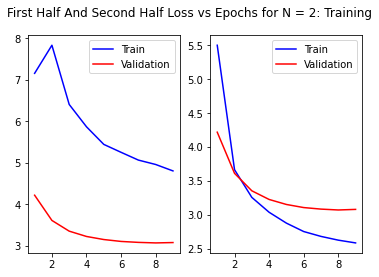

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('First Half And Second Half Loss vs Epochs for N = 2: Training')
X_axis = np.linspace(1, 9, 9)
ax1.plot(X_axis, r_loss[::2], "b", label="Train")
ax1.plot(X_axis, val_loss, "r", label="Validation")
ax1.legend(loc="upper right")
ax2.plot(X_axis, r_loss[1::2], "b", label="Train")
ax2.plot(X_axis, val_loss, "r", label="Validation")
ax2.legend(loc="upper right")
plt.show()

In [ ]:
print(' '.join(val[1].Text))
translate(model, ' '.join(val[1].Text))

In [ ]:
test_loss = []
for item in val:
    if translate(model, item.Text) == item.SQL:
        test_loss.append(1)
    else:
        test_loss.append(0)

print(test_loss.count(1)/len(test_loss) * 100)